In [1]:
%matplotlib inline

In [2]:
import numpy as np
import iopro
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages

In [3]:
save_pdf = True
pdf_fname = 'proposed_sidebands_ratio.pdf'

pp = None
if save_pdf: pp = PdfPages(pdf_fname)

In [4]:
#X = iopro.genfromtxt('data/event_features.csv', names=True, delimiter=',')
X = iopro.genfromtxt('data/sideband_features.csv', names=True, delimiter=',')

In [5]:
typeset_name = { 
    'ny' : r'$n\Upsilon$',
    'ntrk' : r'$N_{track}$',
    'r2' : r'$R_2$',
    'cand_score' : r'Cand.ML',
    'mmiss_prime2' : r'$M^2_{miss}$',
    'eextra50' : r'$E_{extra}$',
    'costhetat' : r'$\cos\theta_T$',
    'tag_lp3' : r'$|\vec{p}^{tag}_\ell|$',
    'tag_cosby' : r'$\cos\theta^{tag}_{B\Upsilon}$',
    'tag_costhetadl' : r'$\cos\theta^{tag}_{D\ell}$',
    'tag_dmass' : r'$m^{tag}_{D}$',
    'tag_deltam' : r'$\Delta m^{tag}$',
    'tag_costhetadsoft' : r'$\cos\theta^{tag}_{Dsoft}$',
    'tag_softp3magcm' : r'$|\vec{p}^{tag}_{soft}|$',
    'sig_hp3' : r'$|\vec{p}^{sig}_{h}|$',
    'sig_cosby' : r'$\cos\theta^{sig}_{B\Upsilon}$',
    'sig_costhetadtau' : r'$\cos\theta^{sig}_{D\tau}$',
    'sig_vtxb' : r'$\chi^2_{sigB}$',
    'sig_dmass' : r'$m^{sig}_{D}$',
    'sig_deltam' : r'$\Delta m^{sig}$',
    'sig_costhetadsoft' : r'$\cos\theta^{sig}_{Dsoft}$',
    'sig_softp3magcm' : r'$|\vec{p}^{sig}_{soft}|$',
    'sig_hmass' : r'$m^{sig}_h$',
    'sig_vtxh' : r'$\chi^2_{sigh}$',
    'tag_dtype' : r'tag $D$ mode',
    'tag_dstartype' : r'tag $D^*$ mode',
    'sig_dtype' : r'sig $D$ mode',
    'sig_dstartype' : r'sig $D^*$ mode',
    'tag_l_epid' : r'tag $\ell$ electron PID',
    'tag_l_mupid' : r'tag $\ell$ muon PID',
    'sig_h_epid' : r'sig $h$ electron PID',
    'sig_h_mupid' : r'sig $h$ muon PID',
    'rf_useopt_score' : r'Sig.ML',
    'rf_dvsdstar_sigmc_score' : r'$D^{*}\tau$.ML', 
}


In [6]:
def group_mc_evttype(X):
    mc_evttypes = X['mc_evttype'].astype(int)
    is_signal = (mc_evttypes == 1) | (mc_evttypes == 2)
    mc_evttypes[is_signal] = 1
    mc_evttypes[~is_signal] = 2
    X['mc_evttype'] = mc_evttypes

group_mc_evttype(X)


In [7]:
def find_cumulative_ratios(X, feature_name):
    X_sig = X[X['mc_evttype']==1]
    X_bkg = X[X['mc_evttype']!=1]

    X_sig.sort(order=feature_name)
    X_bkg.sort(order=feature_name)

    cum_sig = np.cumsum(X_sig['event_weight'])
    cum_bkg = np.cumsum(X_bkg['event_weight'])

    x_min, x_max = np.min(X[feature_name]), np.max(X[feature_name])
    steps = 100
    thresholds = np.linspace(x_min, x_max, steps)

    left_sum_sig, left_sum_bkg = [], []
    for t in thresholds:
        idx = X_sig[feature_name].searchsorted(t,side='right')
        if idx == X_sig.shape[0]: idx -= 1
        left_sum_sig.append(cum_sig[idx])
        
        idx = X_bkg[feature_name].searchsorted(t,side='right')-1
        if idx == X_bkg.shape[0]: idx -= 1
        left_sum_bkg.append(cum_bkg[idx])

    total_sig, total_bkg = np.sum(X_sig['event_weight']), np.sum(X_bkg['event_weight'])
    right_sum_sig, right_sum_bkg = [], []
    for i in range(steps):
        right_sum_sig.append(max(0, total_sig-left_sum_sig[i]))
        right_sum_bkg.append(max(0, total_bkg-left_sum_bkg[i]))

    left_ratio, right_ratio = [], []
    for i in range(steps):
        if left_sum_bkg[i]: 
            left_ratio.append(left_sum_sig[i]/left_sum_bkg[i])
        else:
            left_ratio.append(0)
        if right_sum_bkg[i]: 
            right_ratio.append(right_sum_sig[i]/right_sum_bkg[i])
        else:
            right_ratio.append(0)
    
    return thresholds, np.array(left_ratio), np.array(right_ratio)


In [8]:
thresholds, left_ratio, right_ratio = find_cumulative_ratios(X, 'sig_hp3')

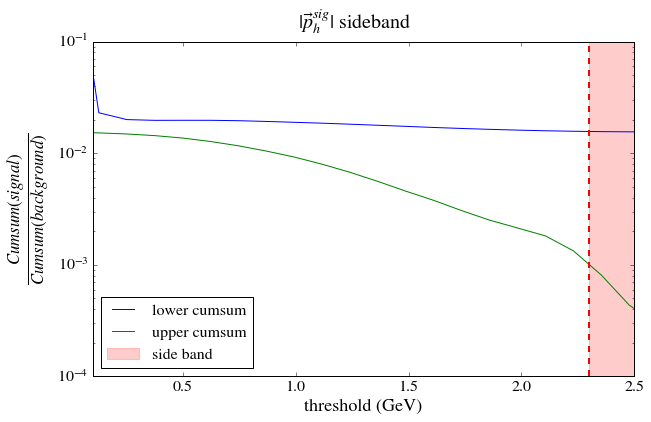

In [9]:
fig = plt.figure(figsize=(6*1.618,6))
ax = fig.add_subplot(1,1,1)
ax.plot(thresholds, left_ratio, label=r'lower cumsum');
ax.plot(thresholds, right_ratio, label='upper cumsum');
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=16);
ax.set_xlabel('threshold (GeV)', fontsize=18);
ax.set_ylabel(r'$\frac{Cumsum(signal)}{Cumsum(background)}$', fontsize=24);
plt.suptitle(typeset_name['sig_hp3']+' sideband', fontsize=20)
plt.plot((2.3, 2.3), (10e-5, 10e2), 'r--', lw=2)
ax.axvspan(2.3, 3, alpha=0.2, color='r', label='side band')
ax.set_xlim(0.1,2.5);
ax.set_ylim(1e-4,1e-1);
plt.legend(fontsize=16, loc=3);

if save_pdf: pp.savefig()

In [10]:
thresholds, left_ratio, right_ratio = find_cumulative_ratios(X, 'eextra50')

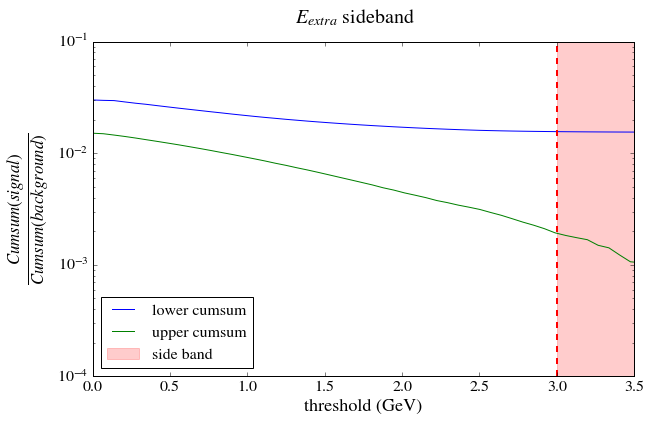

In [11]:
fig = plt.figure(figsize=(6*1.618,6))
ax = fig.add_subplot(1,1,1)
ax.plot(thresholds, left_ratio, label=r'lower cumsum');
ax.plot(thresholds, right_ratio, label='upper cumsum');
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=16);
ax.set_xlabel('threshold (GeV)', fontsize=18);
ax.set_ylabel(r'$\frac{Cumsum(signal)}{Cumsum(background)}$', fontsize=24);
plt.suptitle(typeset_name['eextra50']+' sideband', fontsize=20)
plt.plot((3.0, 3.0), (10e-5, 10e2), 'r--', lw=2)
ax.axvspan(3.0, 10, alpha=0.2, color='r', label='side band')
ax.set_xlim(0.0,3.5);
ax.set_ylim(1e-4,1e-1);
plt.legend(fontsize=16, loc=3);

if save_pdf: pp.savefig()

In [12]:
thresholds, left_ratio, right_ratio = find_cumulative_ratios(X, 'mmiss_prime2')

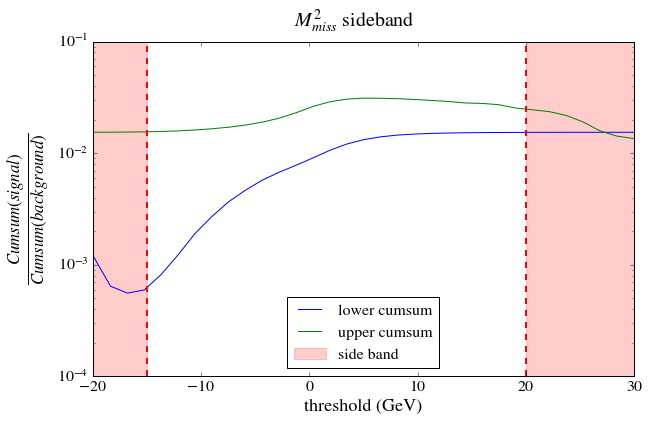

In [13]:
fig = plt.figure(figsize=(6*1.618,6))
ax = fig.add_subplot(1,1,1)
ax.plot(thresholds, left_ratio, label=r'lower cumsum');
ax.plot(thresholds, right_ratio, label='upper cumsum');
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=16);
ax.set_xlabel('threshold (GeV)', fontsize=18);
ax.set_ylabel(r'$\frac{Cumsum(signal)}{Cumsum(background)}$', fontsize=24);
plt.suptitle(typeset_name['mmiss_prime2']+' sideband', fontsize=20)
plt.plot((20.0, 20.0), (10e-5, 10e2), 'r--', lw=2)
ax.axvspan(20.0, 50, alpha=0.2, color='r', label='side band')
plt.plot((-15.0, -15.0), (10e-5, 10e2), 'r--', lw=2)
ax.axvspan(-50, -15, alpha=0.2, color='r')
ax.set_xlim(-20,30);
ax.set_ylim(1e-4,1e-1);
plt.legend(fontsize=16, loc=8);

if save_pdf: pp.savefig()

In [14]:
if save_pdf: pp.close()